<a href="https://colab.research.google.com/github/nasare34/RESEARCH-Automated-Diagnosis-of-Monkeypox-Virus-Utilizing-Skin-Lesion-Imaging-and-AI-Techniques/blob/main/COMPLETE_Monkeypox_research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os


In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.applications import ResNet50
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

# Define the dataset folder path
dataset_path = '/content/drive/My Drive/Monkeypox'
mp_path = os.path.join(dataset_path, 'MP')  # Monkeypox images
nm_path = os.path.join(dataset_path, 'NM')  # Non-monkeypox images


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:


# Define the dataset folder path
dataset_path = '/content/drive/My Drive/Monkeypox'
mp_path = os.path.join(dataset_path, 'MP')  # Monkeypox images
nm_path = os.path.join(dataset_path, 'NM')  # Non-monkeypox images

# Update folder path and subfolders
folder_path = dataset_path
subfolders = ['MP', 'NM']  # Match the original structure: MP for Monkeypox, NM for Non-Monkeypox

# Function to load and preprocess images
def load_and_preprocess_images(folder_path, subfolders):
    label_map = {subfolder: idx for idx, subfolder in enumerate(subfolders)}
    images, labels = [], []

    for subfolder in subfolders:
        subfolder_path = os.path.join(folder_path, subfolder)
        for filename in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (224, 224))  # Resize
                images.append(img)
                labels.append(label_map[subfolder])

    images = np.array(images).astype('float32') / 255.0
    labels = np.array(labels)
    return images, labels

# Load images using the updated paths
images, labels = load_and_preprocess_images(folder_path, subfolders)


#RESNET50

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Define dataset path
dataset_path = '/content/drive/My Drive/Monkeypox'
mp_path = os.path.join(dataset_path, 'MP')  # Monkeypox images
nm_path = os.path.join(dataset_path, 'NM')  # Non-monkeypox images

# Defined image size and batch size
img_height = 224
img_width = 224
batch_size = 5

# Loaded the training and validation datasets
train_ds = image_dataset_from_directory(
    dataset_path,
    label_mode='categorical',  # Used 'categorical' for one-hot encoded labels
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    class_names=['MP', 'NM']  # Specifying the correct class labels
)

val_ds = image_dataset_from_directory(
    dataset_path,
    label_mode='categorical',  # Used 'categorical' for one-hot encoded labels
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    class_names=['MP', 'NM']  # Specify the correct class labels
)

# Define model
model = Sequential()

# Download ResNet50. Removed the `classes` argument since we define that later.
pretrained_model = ResNet50(include_top=False,
                            input_shape=(224, 224, 3),  # Input shape dimension
                            pooling='avg',  # AvgPool
                            weights='imagenet')

# Disable training on ResNet50 layers
for layer in pretrained_model.layers:
    layer.trainable = False

# Add ResNet50 as the feature extractor
model.add(pretrained_model)

# Flatten all data
model.add(Flatten())

# Fully connected layers with 512 neurons
model.add(Dense(512, activation='relu'))

# Output layer with 2 neurons (for Monkeypox and Non-Monkeypox)
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=[early_stop])



Found 228 files belonging to 2 classes.
Using 183 files for training.
Found 228 files belonging to 2 classes.
Using 45 files for validation.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 2048)                │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,637,826 (93.99 MB)

 Trainable params: 1,050,114 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.5682 - loss: 0.7468 - val_accuracy: 0.4889 - val_loss: 0.6980
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.6328 - loss: 0.6652 - val_accuracy: 0.5333 - val_loss: 0.6132
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.6536 - loss: 0.6213 - val_accuracy: 0.6444 - val_loss: 0.5645
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.6751 - loss: 0.5811 - val_accuracy: 0.6889 - val_loss: 0.5242
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.7751 - loss: 0.5124 - val_accuracy: 0.7556 - val_loss: 0.4860
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.8136 - loss: 0.4549 - val_accuracy: 0.8000 - val_loss: 0.4653
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.8346 - loss: 0.4186 - val_accuracy: 0.8222 - val_loss: 0.4449
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.8215 - loss: 0.4205 - val_accuracy: 0.8444 - val_loss:

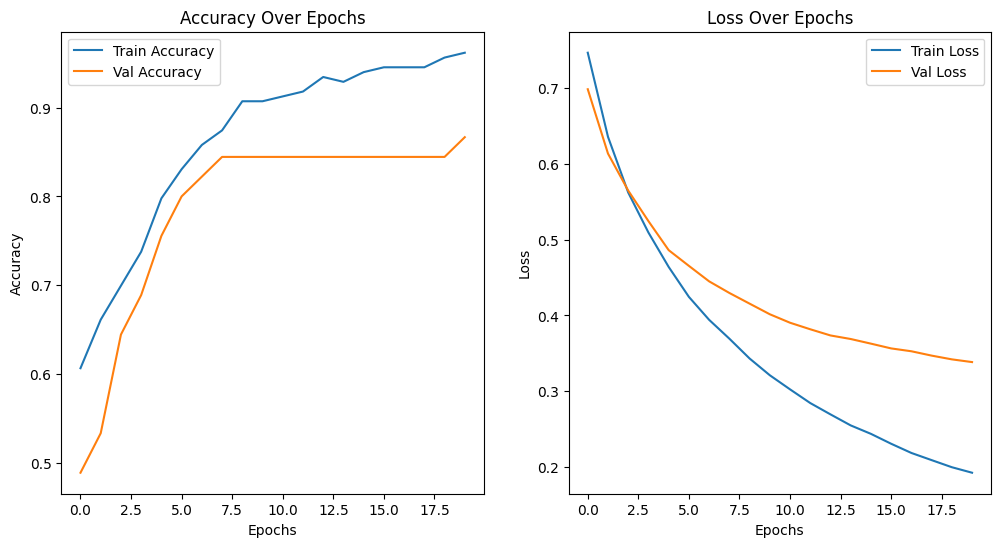

In [ ]:
# Visualize training results
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#validation

VALIDATION

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 773ms/step - accuracy: 0.8891 - loss: 0.2950
validation Loss: 0.3386 - validation Accuracy: 0.8667


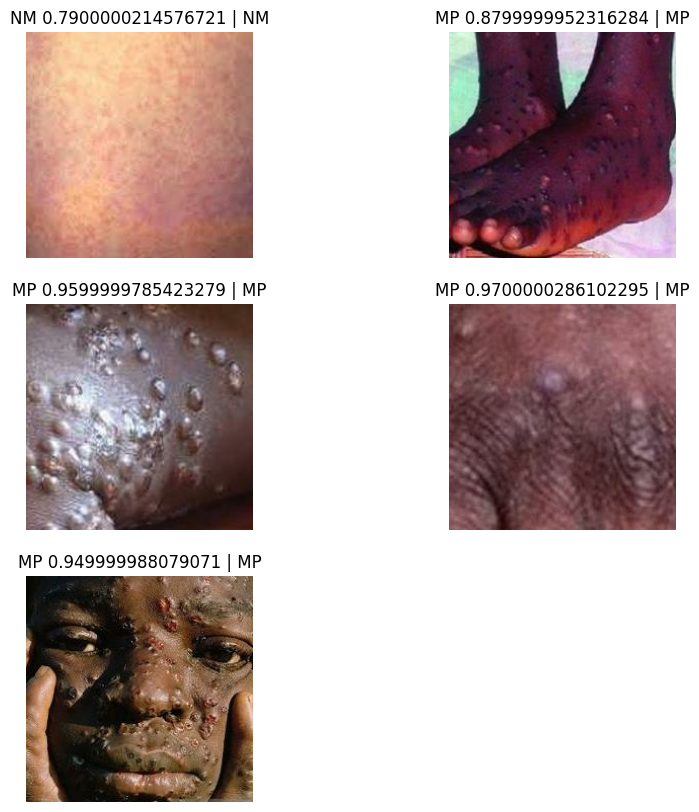

In [ ]:
# Visualizing predictions on validation set
class_names = ['MP', 'NM']

plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
    # Get the number of images in the batch
    num_images = len(images)
    # Calculate rows and columns for the subplot grid
    # You might need to adjust these based on your batch size
    num_rows = int(np.ceil(np.sqrt(num_images)))
    num_cols = int(np.ceil(num_images / num_rows))

    for i in range(num_images):
        result = model(np.expand_dims(images[i], axis=0))  # Make prediction for each image
        # Use num_rows and num_cols to dynamically create subplots
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class = class_names[np.argmax(result)]  # Get the predicted class
        true_class = class_names[np.argmax(labels[i])]  # Get the true class
        plt.title(f"{predicted_class} {round(np.max(result), 2)} | {true_class}")
        plt.axis("off")

# Evaluate the model on val set
test_loss, test_accuracy = model.evaluate(val_ds)  # Use validation data here as a test
print(f"validation Loss: {test_loss:.4f} - validation Accuracy: {test_accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.74      0.82        19
           1       0.83      0.96      0.89        26

    accuracy                           0.87        45
   macro avg       0.88      0.85      0.86        45
weighted avg       0.88      0.87      0.86        45



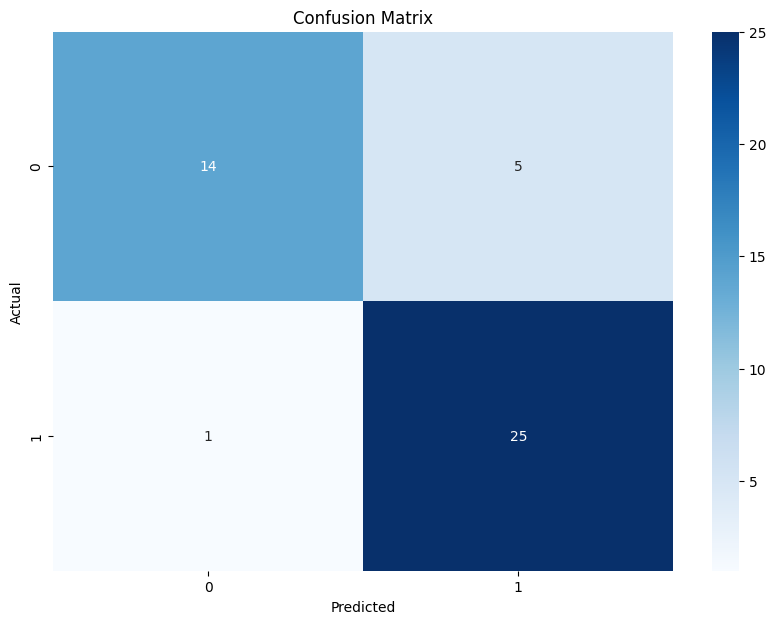

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns



# Step 1: Make predictions on the validation set and extract labels
val_labels = []  # Initialize an empty list to store true labels
val_predictions = []  # Initialize an empty list to store predictions

for images, labels in val_ds:
    val_labels.extend(np.argmax(labels.numpy(), axis=1))  # Append true labels
    predictions = model.predict(images)
    val_predictions.extend(np.argmax(predictions, axis=1))  # Append predicted labels

# Convert the lists to NumPy arrays
val_labels = np.array(val_labels)
val_predictions = np.array(val_predictions)

# Step 2: Compute the confusion matrix and classification report
cm = confusion_matrix(val_labels, val_predictions)
class_report = classification_report(val_labels, val_predictions)

print("Classification Report:")
print(class_report)

# Step 3: Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(val_labels), yticklabels=np.unique(val_labels))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

TESTING

In [ ]:
import os
import cv2
import numpy as np

# Defined the dataset path
dataset_path = '/content/drive/My Drive/Monkeypox'
mp_path = os.path.join(dataset_path, 'MP')  # Monkeypox images
nm_path = os.path.join(dataset_path, 'NM')  # Non-monkeypox images

# Defined the function to load and preprocess images
def load_and_preprocess_images(folder_path, subfolders):
    label_map = {subfolder: idx for idx, subfolder in enumerate(subfolders)}
    images, labels = [], []

    for subfolder in subfolders:
        subfolder_path = os.path.join(folder_path, subfolder)
        for filename in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (224, 224))  # Resize to 224x224
                images.append(img)
                labels.append(label_map[subfolder])

    images = np.array(images).astype('float32') / 255.0  # Normalize images
    labels = np.array(labels)
    return images, labels

# Combine Monkeypox and Non-monkeypox images into one test set
subfolders = ['MP', 'NM']  # Subfolders: MP for Monkeypox, NM for Non-monkeypox
test_images, test_labels = load_and_preprocess_images(dataset_path, subfolders)

print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")


Test images shape: (228, 224, 224, 3)
Test labels shape: (228,)


In [ ]:
test_ds = image_dataset_from_directory(
    dataset_path,
    label_mode='categorical',  # Ensure one-hot encoding
    image_size=(img_height, img_width),
    batch_size=batch_size,
    class_names=['MP', 'NM']  # Same class names as training
)

# Evaluate the model on the test set
resnet_loss, resnet_accuracy = model.evaluate(test_ds, verbose=1)
print(f"ResNet Model Test Loss: {resnet_loss:.4f} - Test Accuracy: {resnet_accuracy:.4f}")


Found 228 files belonging to 2 classes.
46/46 ━━━━━━━━━━━━━━━━━━━━ 43s 939ms/step - accuracy: 0.9436 - loss: 0.2106
ResNet Model Test Loss: 0.2138 - Test Accuracy: 0.9430


Found 228 files belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step
1/1 ━━━━━

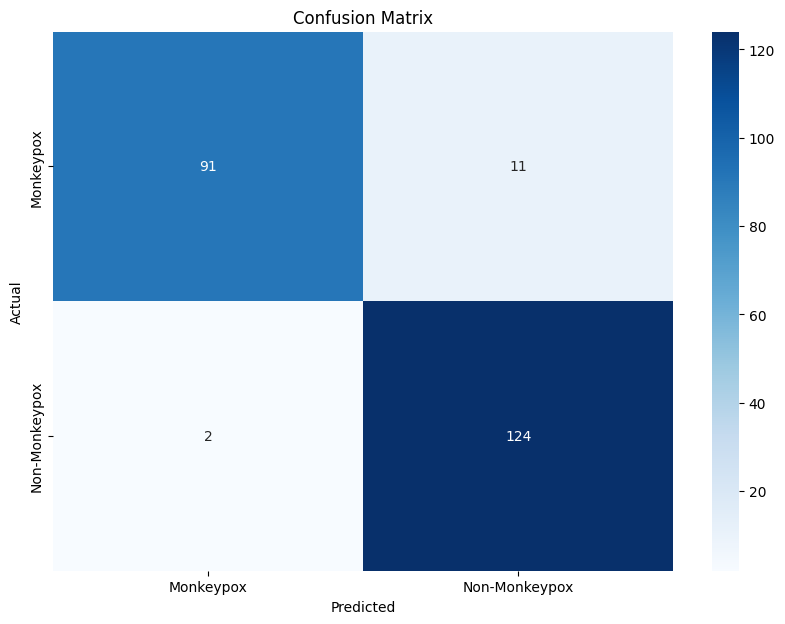

In [ ]:
# Step 1: Loaded the complete dataset (training + validation as a single dataset)
complete_ds = image_dataset_from_directory(
    dataset_path,
    label_mode='categorical',  # Use 'categorical' for one-hot encoded labels
    validation_split=None,     # Load the full dataset
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    class_names=['MP', 'NM']   # Specify the correct class labels
)

# Step 2: Make predictions on the complete dataset and extract labels
complete_labels = []  # Initialize an empty list to store true labels
complete_predictions = []  # Initialize an empty list to store predictions

for images, labels in complete_ds:
    complete_labels.extend(np.argmax(labels.numpy(), axis=1))  # Append true labels
    predictions = model.predict(images)
    complete_predictions.extend(np.argmax(predictions, axis=1))  # Append predicted labels

# Convert the lists to NumPy arrays
complete_labels = np.array(complete_labels)
complete_predictions = np.array(complete_predictions)

# Step 3: Compute the confusion matrix and classification report
cm = confusion_matrix(complete_labels, complete_predictions)
class_report = classification_report(complete_labels, complete_predictions, target_names=['Monkeypox', 'Non-Monkeypox'])

print("Classification Report:")
print(class_report)

# Step 4: Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Monkeypox', 'Non-Monkeypox'], yticklabels=['Monkeypox', 'Non-Monkeypox'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━

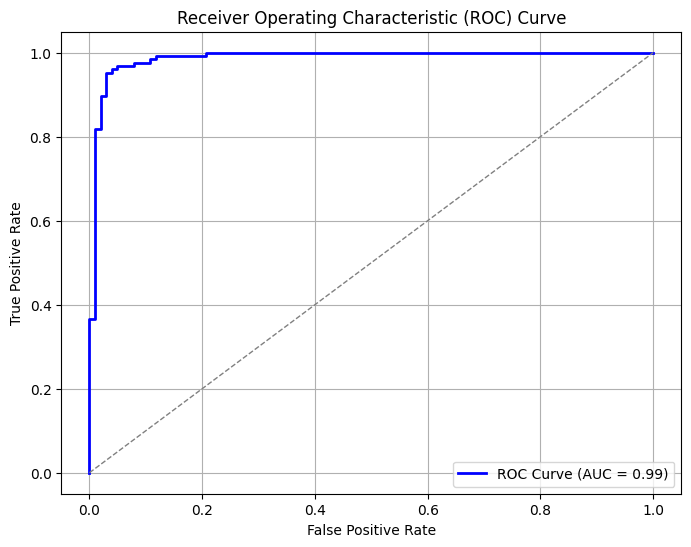

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Step 1: Get true labels and predicted probabilities for the complete dataset
complete_labels = []  # True labels
complete_probs = []   # Predicted probabilities

for images, labels in complete_ds:
    complete_labels.extend(np.argmax(labels.numpy(), axis=1))  # True labels (convert from one-hot)
    predictions = model.predict(images)  # Get predicted probabilities
    complete_probs.extend(predictions[:, 1])  # Probabilities for class '1' (Non-Monkeypox)

# Convert to NumPy arrays
complete_labels = np.array(complete_labels)
complete_probs = np.array(complete_probs)

# Step 2: Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(complete_labels, complete_probs)
roc_auc = auc(fpr, tpr)

# Step 3: Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [ ]:
def get_model_memory_usage(model, batch_size=1):
    """Calculates the approximate memory usage of a Keras model.

    Args:
        model: The Keras model.
        batch_size: The batch size used for inference.

    Returns:
        The approximate memory usage of the model in megabytes (MB).
    """
    # Memory for model parameters
    trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_variables])
    non_trainable_params = np.sum([np.prod(v.shape) for v in model.non_trainable_variables])
    total_params = trainable_params + non_trainable_params
    params_memory = total_params * 4  # Assuming 32-bit floats (4 bytes per float)

    # Memory for activations (forward pass only)
    feature_map_memory = 0
    for layer in model.layers:

        # Check if the layer has an output_shape attribute
        if hasattr(layer, 'output_shape'):
            output_shape = layer.output_shape

            # Check if output_shape is valid for calculation
            if output_shape and all(dim is not None for dim in output_shape):
                if isinstance(output_shape, list):  # Multiple outputs
                    feature_map_memory += sum([np.prod(shape) for shape in output_shape if shape])
                else:
                    feature_map_memory += np.prod(output_shape)

    feature_map_memory *= batch_size * 4  # 32-bit floats

    total_memory = params_memory + feature_map_memory
    return total_memory / (1024 ** 2)  # Convert to MB


In [ ]:
# Call the function with your model and batch size
memory_usage = get_model_memory_usage(model, batch_size=1)

# Print the memory usage
print(f"Approximate Model Memory Usage: {memory_usage:.2f} MB")


Approximate Model Memory Usage: 93.99 MB


In [ ]:
import time
import numpy as np

# Generate a random input tensor with the same shape as the model's input
input_shape = (1, 224, 224, 3)  # Adjust as per your model's input dimensions
random_input = np.random.random(input_shape).astype(np.float32)

# Warm-up the model to ensure accurate timing (optional but recommended)
for _ in range(5):
    _ = model.predict(random_input)

# Measure inference time
start_time = time.time()
_ = model.predict(random_input)  # Perform a single forward pass
end_time = time.time()

# Calculate and print the inference time
inference_time = end_time - start_time
print(f"Inference Time for a single input: {inference_time:.6f} seconds")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
Inference Time for a single input: 0.258832 seconds


In [ ]:
import time
import numpy as np

# Assuming you have a dataset named `complete_ds`
# Batch size is defined in `complete_ds`

total_time = 0  # Initialize total time

# Warm-up the model (optional but recommended)
warmup_input = np.random.random((1, 224, 224, 3)).astype(np.float32)
for _ in range(5):
    _ = model.predict(warmup_input)

# Measure inference time over the entire dataset
for images, _ in complete_ds:  # Loop through batches in the dataset
    start_time = time.time()
    _ = model.predict(images)
    end_time = time.time()
    total_time += (end_time - start_time)

print(f"Total Inference Time for the entire dataset: {total_time:.6f} seconds")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━

In [ ]:
import tensorflow as tf

def get_model_flops(model, batch_size=5, input_shape=(224, 224, 3)):
    """
    Calculate the FLOPs (Floating Point Operations) of the model.

    Args:
        model: The Keras model.
        batch_size: The batch size used for inference.
        input_shape: The shape of the input tensor (excluding batch size).

    Returns:
        The approximate number of FLOPs for a single forward pass of the model.
    """
    dy_input = tf.random.normal([batch_size] + list(input_shape))

    # Create a concrete function from the model
    concrete_func = tf.function(model).get_concrete_function(dy_input)

    # Use TensorFlow's profiler to trace the operations and calculate FLOPs
    flops = tf.compat.v1.profiler.profile(
        graph=concrete_func.graph,
        options=tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    )

    # Print the total FLOPs (in GFLOPs)
    total_flops = flops.total_float_ops
    print(f"Total FLOPs: {total_flops}")
    print(f"Approximate FLOPs for a forward pass: {total_flops / 1e9:.2f} GFLOPs")
    return total_flops

# Get and print the FLOPs of the model
flops = get_model_flops(model, batch_size=5, input_shape=(224, 224, 3))

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


Total FLOPs: 38765847740
Approximate FLOPs for a forward pass: 38.77 GFLOPs


#MOBILENET

Found 228 files belonging to 2 classes.
Using 183 files for training.
Found 228 files belonging to 2 classes.
Using 45 files for validation.


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 1280)                │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,914,882 (11.12 MB)

 Trainable params: 656,898 (2.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.4760 - loss: 0.7749 - val_accuracy: 0.6667 - val_loss: 0.6216
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6521 - loss: 0.6539 - val_accuracy: 0.6889 - val_loss: 0.5521
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6598 - loss: 0.6215 - val_accuracy: 0.7111 - val_loss: 0.5334
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.7229 - loss: 0.5662 - val_accuracy: 0.6444 - val_loss: 0.5553
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7216 - loss: 0.5434 - val_accuracy: 0.6889 - val_loss: 0.5444
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7546 - loss: 0.5171 - val_accuracy: 0.6889 - val_loss: 0.5519
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7927 - loss: 0.4979 - val_accuracy: 0.6889 - val_loss: 0.5440
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.7835 - loss: 0.4796 - val_accuracy: 0.7556 - val_loss: 0.5081
Epoch 9/

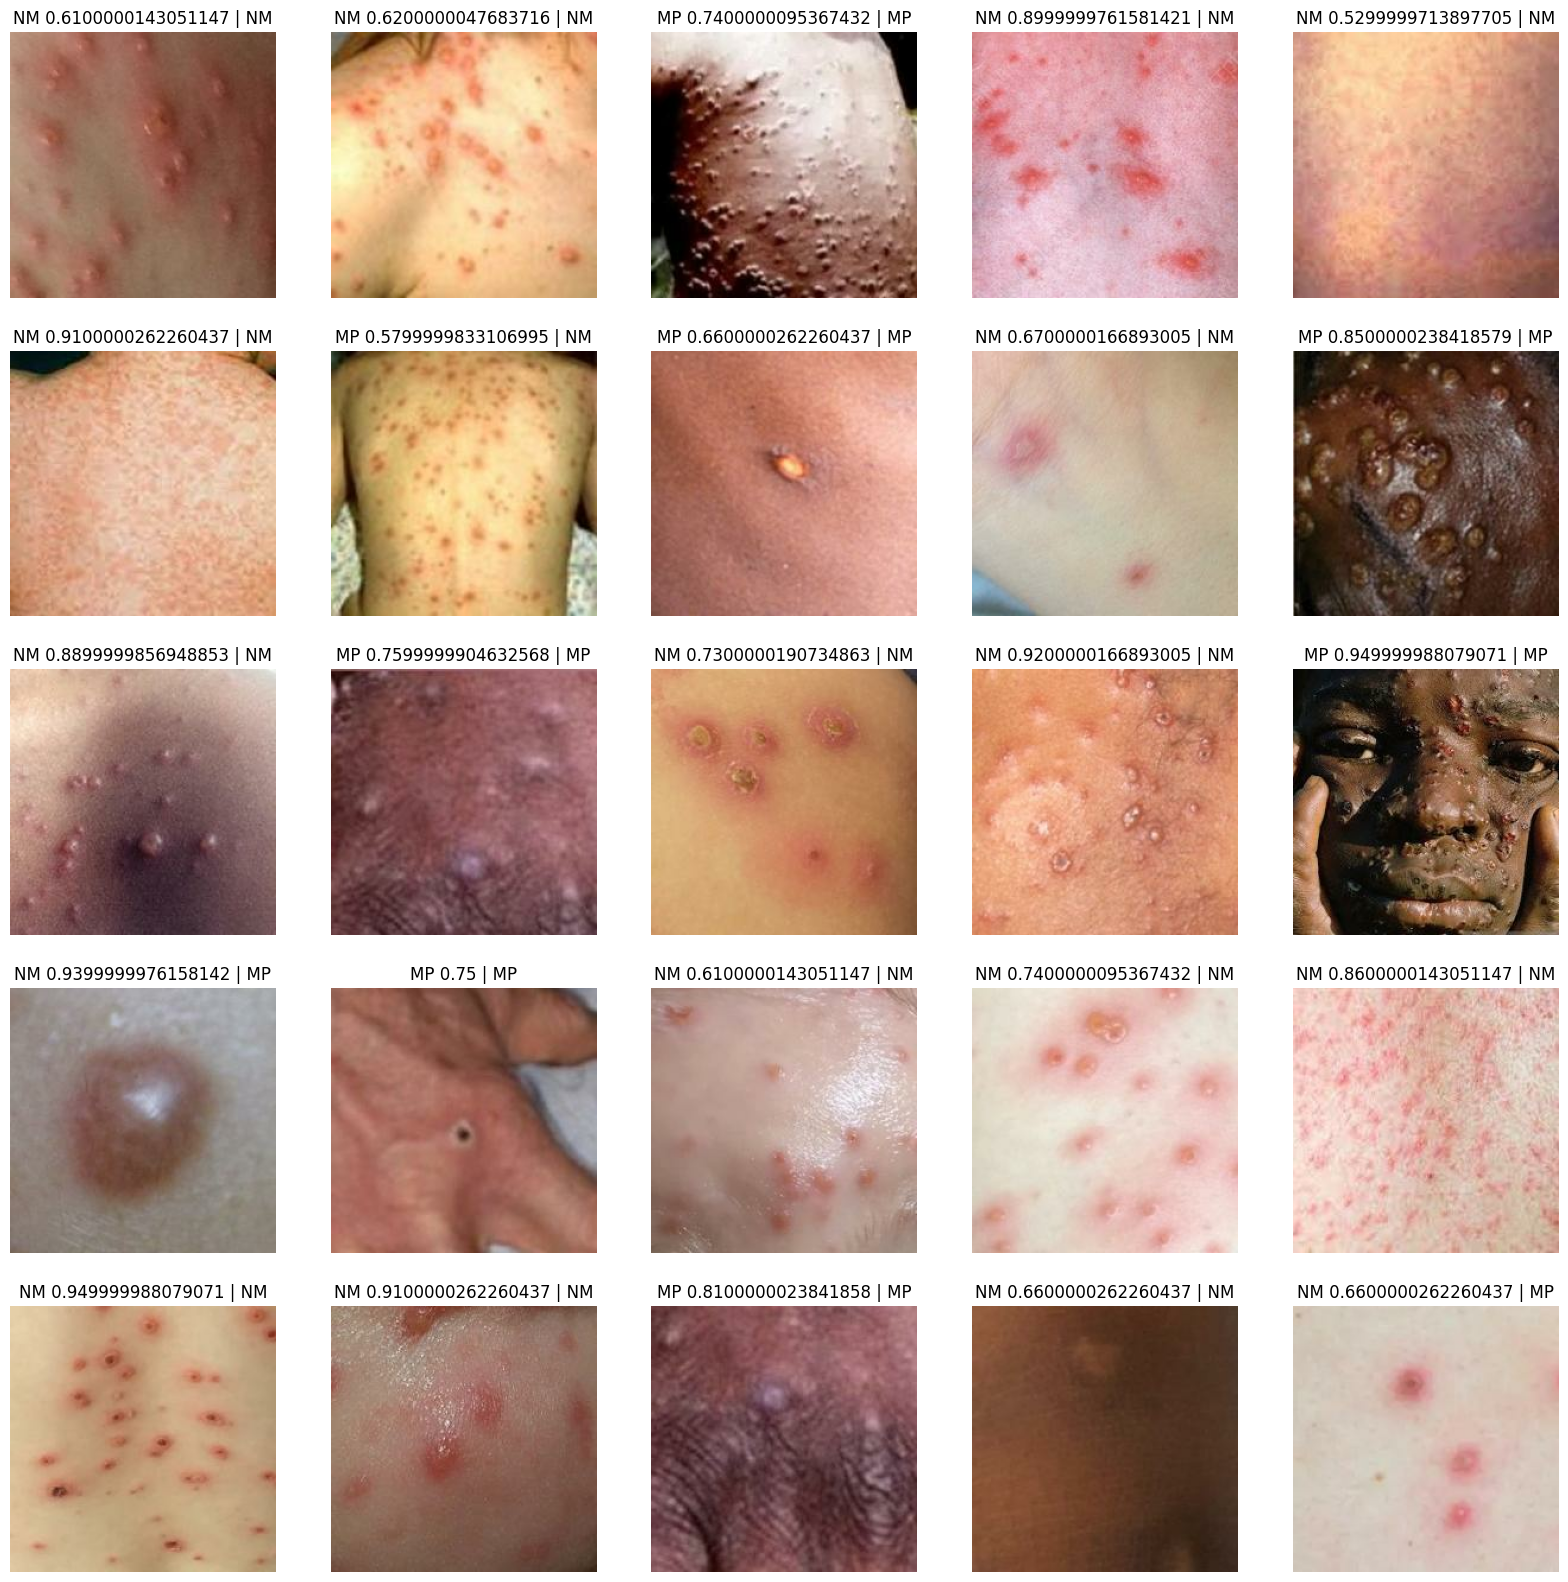

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Define dataset path
dataset_path = '/content/drive/My Drive/Monkeypox'
mp_path = os.path.join(dataset_path, 'MP')  # Monkeypox images
nm_path = os.path.join(dataset_path, 'NM')  # Non-monkeypox images

# Define image size and batch size
img_height = 224
img_width = 224
batch_size = 25

# Load the training and validation datasets
train_ds = image_dataset_from_directory(
    dataset_path,
    label_mode='categorical',  # Use 'categorical' for one-hot encoded labels
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    class_names=['MP', 'NM']  # Specify the correct class labels
)

val_ds = image_dataset_from_directory(
    dataset_path,
    label_mode='categorical',  # Use 'categorical' for one-hot encoded labels
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    class_names=['MP', 'NM']  # Specify the correct class labels
)

# Define model
model = Sequential()

# Download MobileNetV2. Removed the `classes` argument since we define that later.
pretrained_model = MobileNetV2(include_top=False,
                               input_shape=(224, 224, 3),  # Input shape dimension
                               pooling='avg',  # AvgPool
                               weights='imagenet')

# Disable training on MobileNetV2 layers
for layer in pretrained_model.layers:
    layer.trainable = False

# Add MobileNetV2 as the feature extractor
model.add(pretrained_model)

# Flatten all data
model.add(Flatten())

# Fully connected layers with 512 neurons
model.add(Dense(512, activation='relu'))

# Output layer with 2 neurons (for Monkeypox and Non-Monkeypox)
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[early_stop])

# Visualizing predictions on validation set
class_names = ['MP', 'NM']

plt.figure(figsize=(20, 20))
for images, labels in val_ds.take(1):
    # Get the number of images in the batch
    num_images = len(images)
    # Calculate rows and columns for the subplot grid
    # You might need to adjust these based on your batch size
    num_rows = int(np.ceil(np.sqrt(num_images)))
    num_cols = int(np.ceil(num_images / num_rows))

    for i in range(num_images):
        result = model(np.expand_dims(images[i], axis=0))  # Make prediction for each image
        # Use num_rows and num_cols to dynamically create subplots
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class = class_names[np.argmax(result)]  # Get the predicted class
        true_class = class_names[np.argmax(labels[i])]  # Get the true class
        plt.title(f"{predicted_class} {round(np.max(result), 2)} | {true_class}")
        plt.axis("off")



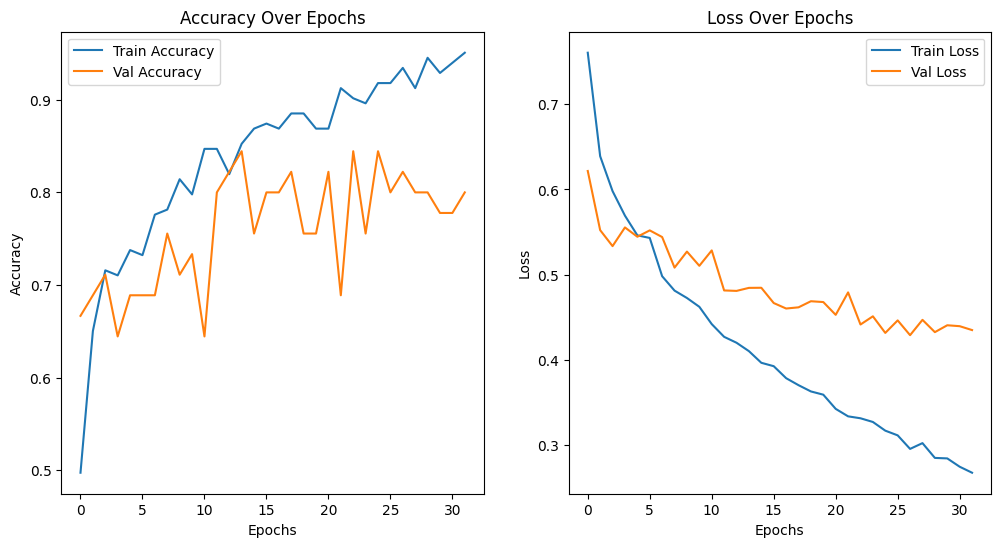

In [ ]:
# Visualized training results
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#VALIDATION

validation

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 706ms/step - accuracy: 0.8015 - loss: 0.4558
validation Loss: 0.4288 - Validation Accuracy: 0.8222


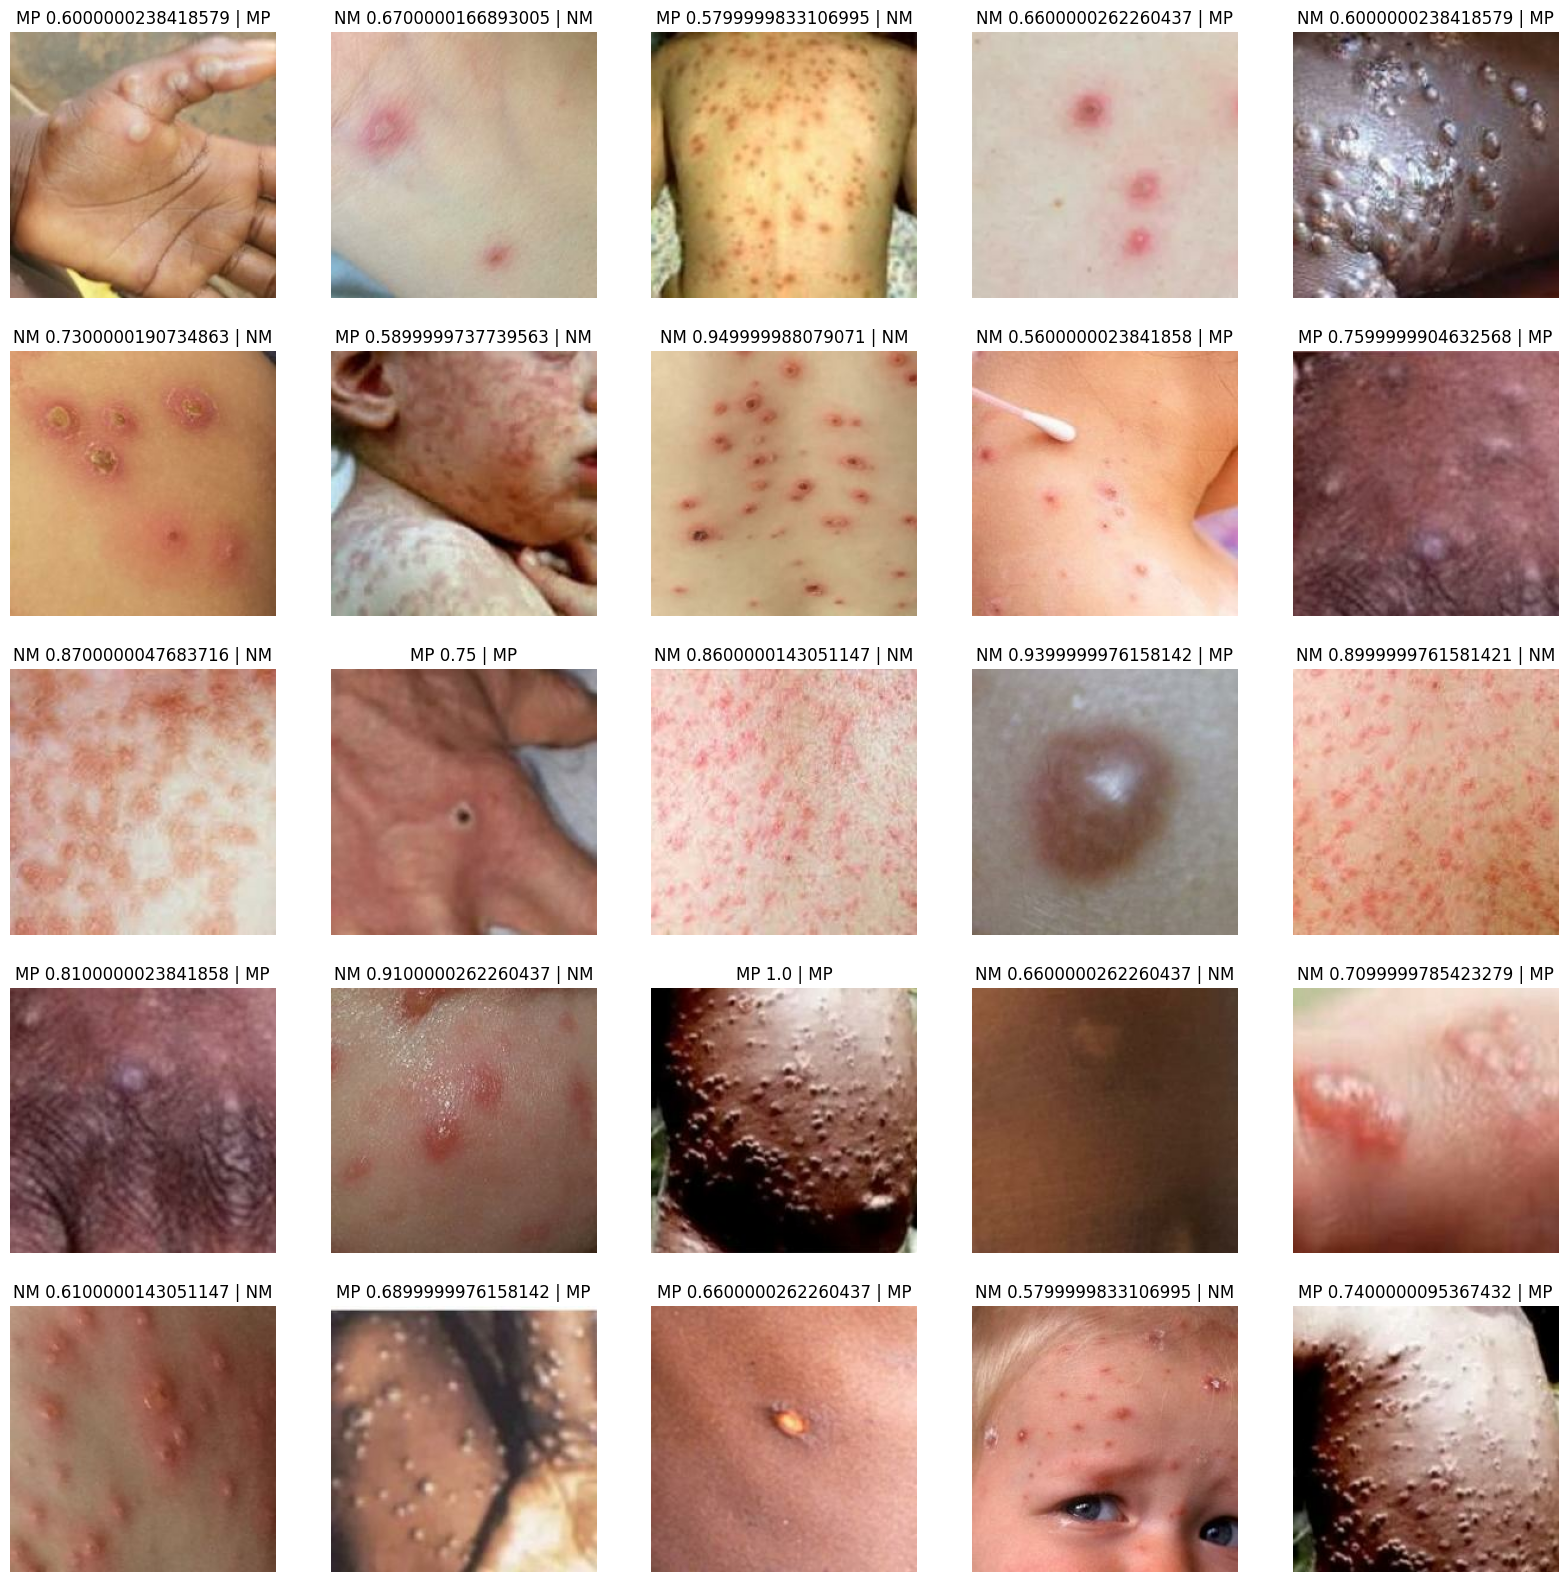

In [ ]:
# Visualizing predictions on validation set
class_names = ['MP', 'NM']

plt.figure(figsize=(20, 20))
for images, labels in val_ds.take(1):
    # Get the number of images in the batch
    num_images = len(images)
    # Calculate rows and columns for the subplot grid
    # You might need to adjust these based on your batch size
    num_rows = int(np.ceil(np.sqrt(num_images)))
    num_cols = int(np.ceil(num_images / num_rows))

    for i in range(num_images):
        result = model(np.expand_dims(images[i], axis=0))  # Make prediction for each image
        # Use num_rows and num_cols to dynamically create subplots
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class = class_names[np.argmax(result)]  # Get the predicted class
        true_class = class_names[np.argmax(labels[i])]  # Get the true class
        plt.title(f"{predicted_class} {round(np.max(result), 2)} | {true_class}")
        plt.axis("off")

# Evaluate the model on test set (assuming test_ds is available)
test_loss, test_accuracy = model.evaluate(val_ds)  # Use validation data here as a test
print(f"validation Loss: {test_loss:.4f} - Validation Accuracy: {test_accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.68      0.76        19
           1       0.80      0.92      0.86        26

    accuracy                           0.82        45
   macro avg       0.83      0.80      0.81        45
weighted avg       0.83      0.82      0.82        45



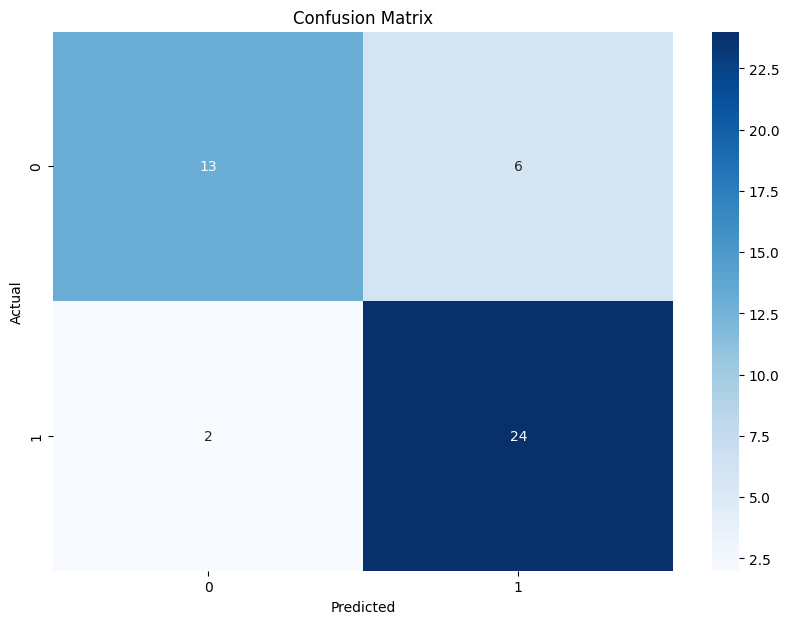

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Assuming you have already trained your model as indicated in your snippet
# 'model' is your trained model, and 'val_ds' is your validation dataset

# Step 1: Make predictions on the validation set and extract labels
val_labels = []  # Initialize an empty list to store true labels
val_predictions = []  # Initialize an empty list to store predictions

for images, labels in val_ds:
    val_labels.extend(np.argmax(labels.numpy(), axis=1))  # Append true labels
    predictions = model.predict(images)
    val_predictions.extend(np.argmax(predictions, axis=1))  # Append predicted labels

# Convert the lists to NumPy arrays
val_labels = np.array(val_labels)
val_predictions = np.array(val_predictions)

# Step 2: Compute the confusion matrix and classification report
cm = confusion_matrix(val_labels, val_predictions)
class_report = classification_report(val_labels, val_predictions)

print("Classification Report:")
print(class_report)

# Step 3: Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(val_labels), yticklabels=np.unique(val_labels))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Evaluate the model on test set (assuming test_ds is available)
test_loss, test_accuracy = model.evaluate(val_ds)  # Use validation data here as a test
print(f"Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 763ms/step - accuracy: 0.8281 - loss: 0.4195
Test Loss: 0.4288 - Test Accuracy: 0.8222


TESTING

In [ ]:
import os
import cv2
import numpy as np

# Defined the dataset path
dataset_path = '/content/drive/My Drive/Monkeypox'
mp_path = os.path.join(dataset_path, 'MP')  # Monkeypox images
nm_path = os.path.join(dataset_path, 'NM')  # Non-monkeypox images

# Define the function to load and preprocess images
def load_and_preprocess_images(folder_path, subfolders):
    label_map = {subfolder: idx for idx, subfolder in enumerate(subfolders)}
    images, labels = [], []

    for subfolder in subfolders:
        subfolder_path = os.path.join(folder_path, subfolder)
        for filename in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (224, 224))  # Resize to 224x224
                images.append(img)
                labels.append(label_map[subfolder])

    images = np.array(images).astype('float32') / 255.0  # Normalize images
    labels = np.array(labels)
    return images, labels

# Combine Monkeypox and Non-monkeypox images into one test set
subfolders = ['MP', 'NM']  # Subfolders: MP for Monkeypox, NM for Non-monkeypox
test_images, test_labels = load_and_preprocess_images(dataset_path, subfolders)

print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")


Test images shape: (228, 224, 224, 3)
Test labels shape: (228,)


In [ ]:

# Load the test dataset
test_ds = image_dataset_from_directory(
    dataset_path,
    label_mode='categorical',  # Ensure one-hot encoding
    image_size=(img_height, img_width),
    batch_size=batch_size,
    class_names=['MP', 'NM']  # Same class names as training
)

# Evaluate the MobileNetV2 model on the test set
mobilenet_loss, mobilenet_accuracy = model.evaluate(test_ds, verbose=1)

# Print the results
print(f"MobileNetV2 Model Test Loss: {mobilenet_loss:.4f} - Test Accuracy: {mobilenet_accuracy:.4f}")


Found 228 files belonging to 2 classes.
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 893ms/step - accuracy: 0.9268 - loss: 0.3226
MobileNetV2 Model Test Loss: 0.3248 - Test Accuracy: 0.9035


Found 228 files belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Classification Report:
               precision    recall  f1-score   support

    Monkeypox       0.97      0.81      0.88       102
Non-Monkeypox       0.87      0.98      0.92       126

     accuracy                           0.90       228
    macro avg       0.92      0.89      0.90       228
 weighted avg       0.91      0.90      0.90       228



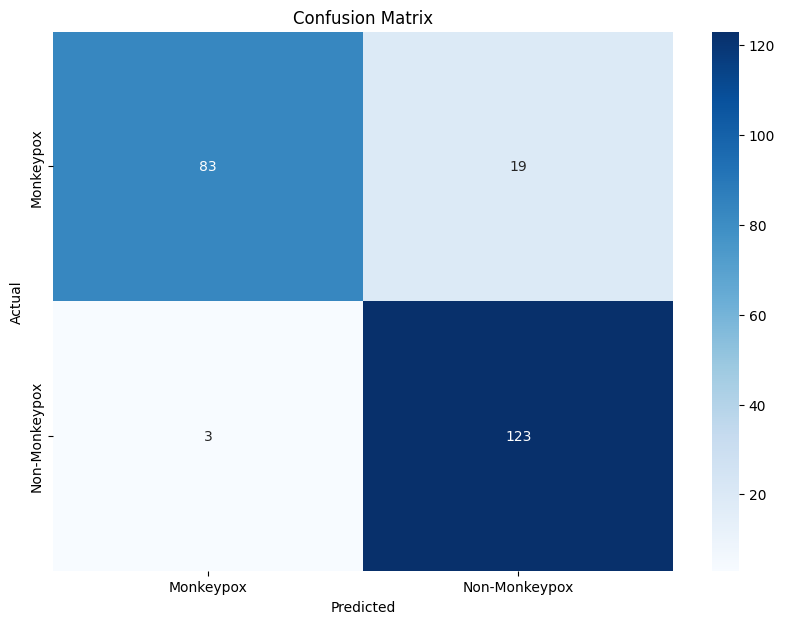

In [ ]:
# Step 1: Load the complete dataset (training + validation as a single dataset)
complete_ds = image_dataset_from_directory(
    dataset_path,
    label_mode='categorical',  # Use 'categorical' for one-hot encoded labels
    validation_split=None,     # Load the full dataset
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    class_names=['MP', 'NM']   # Specify the correct class labels
)

# Step 2: Make predictions on the complete dataset and extract labels
complete_labels = []  # Initialize an empty list to store true labels
complete_predictions = []  # Initialize an empty list to store predictions

for images, labels in complete_ds:
    complete_labels.extend(np.argmax(labels.numpy(), axis=1))  # Append true labels
    predictions = model.predict(images)
    complete_predictions.extend(np.argmax(predictions, axis=1))  # Append predicted labels

# Convert the lists to NumPy arrays
complete_labels = np.array(complete_labels)
complete_predictions = np.array(complete_predictions)

# Step 3: Compute the confusion matrix and classification report
cm = confusion_matrix(complete_labels, complete_predictions)
class_report = classification_report(complete_labels, complete_predictions, target_names=['Monkeypox', 'Non-Monkeypox'])

print("Classification Report:")
print(class_report)

# Step 4: Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Monkeypox', 'Non-Monkeypox'], yticklabels=['Monkeypox', 'Non-Monkeypox'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 922ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


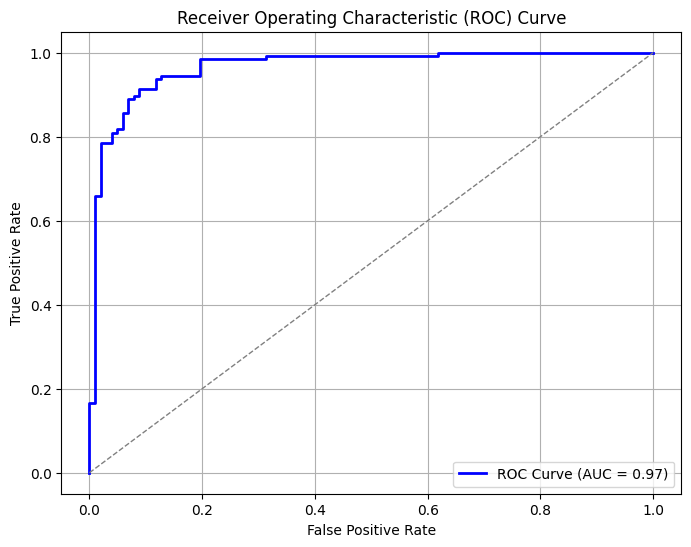

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Step 1: Get true labels and predicted probabilities for the complete dataset
complete_labels = []  # True labels
complete_probs = []   # Predicted probabilities

for images, labels in complete_ds:
    complete_labels.extend(np.argmax(labels.numpy(), axis=1))  # True labels (convert from one-hot)
    predictions = model.predict(images)  # Get predicted probabilities
    complete_probs.extend(predictions[:, 1])  # Probabilities for class '1' (Non-Monkeypox)

# Convert to NumPy arrays
complete_labels = np.array(complete_labels)
complete_probs = np.array(complete_probs)

# Step 2: Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(complete_labels, complete_probs)
roc_auc = auc(fpr, tpr)

# Step 3: Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [ ]:
def get_model_memory_usage(model, batch_size=1):
    """Calculates the approximate memory usage of a Keras model.

    Args:
        model: The Keras model.
        batch_size: The batch size used for inference.

    Returns:
        The approximate memory usage of the model in megabytes (MB).
    """
    # Memory for model parameters
    trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_variables])
    non_trainable_params = np.sum([np.prod(v.shape) for v in model.non_trainable_variables])
    total_params = trainable_params + non_trainable_params
    params_memory = total_params * 4  # Assuming 32-bit floats (4 bytes per float)

    # Memory for activations (forward pass only)
    feature_map_memory = 0
    for layer in model.layers:

        # Check if the layer has an output_shape attribute
        if hasattr(layer, 'output_shape'):
            output_shape = layer.output_shape

            # Check if output_shape is valid for calculation
            if output_shape and all(dim is not None for dim in output_shape):
                if isinstance(output_shape, list):  # Multiple outputs
                    feature_map_memory += sum([np.prod(shape) for shape in output_shape if shape])
                else:
                    feature_map_memory += np.prod(output_shape)

    feature_map_memory *= batch_size * 4  # 32-bit floats

    total_memory = params_memory + feature_map_memory
    return total_memory / (1024 ** 2)  # Convert to MB
# Call the function with your model and batch size
memory_usage = get_model_memory_usage(model, batch_size=1)

# Print the memory usage
print(f"Approximate Model Memory Usage: {memory_usage:.2f} MB")


Approximate Model Memory Usage: 11.12 MB


In [ ]:
import tensorflow as tf

def get_model_flops(model, batch_size=5, input_shape=(224, 224, 3)):
    """
    Calculate the FLOPs (Floating Point Operations) of the model.

    Args:
        model: The Keras model.
        batch_size: The batch size used for inference.
        input_shape: The shape of the input tensor (excluding batch size).

    Returns:
        The approximate number of FLOPs for a single forward pass of the model.
    """
    dy_input = tf.random.normal([batch_size] + list(input_shape))

    # Create a concrete function from the model
    concrete_func = tf.function(model).get_concrete_function(dy_input)

    # Use TensorFlow's profiler to trace the operations and calculate FLOPs
    flops = tf.compat.v1.profiler.profile(
        graph=concrete_func.graph,
        options=tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    )

    # Print the total FLOPs (in GFLOPs)
    total_flops = flops.total_float_ops
    print(f"Total FLOPs: {total_flops}")
    print(f"Approximate FLOPs for a forward pass: {total_flops / 1e9:.2f} GFLOPs")
    return total_flops

# Get and print the FLOPs of the model
flops = get_model_flops(model, batch_size=5, input_shape=(224, 224, 3))

Total FLOPs: 3069788156
Approximate FLOPs for a forward pass: 3.07 GFLOPs


In [ ]:
import time
import numpy as np

# Generate a random input tensor with the same shape as the model's input
input_shape = (1, 224, 224, 3)  # Adjust as per your model's input dimensions
random_input = np.random.random(input_shape).astype(np.float32)

# Warm-up the model to ensure accurate timing (optional but recommended)
for _ in range(5):
    _ = model.predict(random_input)

# Measure inference time
start_time = time.time()
_ = model.predict(random_input)  # Perform a single forward pass
end_time = time.time()

# Calculate and print the inference time
inference_time = end_time - start_time
print(f"Inference Time for a single input: {inference_time:.6f} seconds")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Inference Time for a single input: 0.105204 seconds


#EFFICIENTNETB0

#EFFICIENTNETB0

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0  # Import the latest EfficientNet model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Define dataset path
dataset_path = '/content/drive/My Drive/Monkeypox'
mp_path = os.path.join(dataset_path, 'MP')  # Monkeypox images
nm_path = os.path.join(dataset_path, 'NM')  # Non-monkeypox images

# Define image size and batch size
img_height = 224
img_width = 224
batch_size = 5

# Load the training and validation datasets
train_ds = image_dataset_from_directory(
    dataset_path,
    label_mode='categorical',  # Use 'categorical' for one-hot encoded labels
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    class_names=['MP', 'NM']  # Specify the correct class labels
)

val_ds = image_dataset_from_directory(
    dataset_path,
    label_mode='categorical',  # Use 'categorical' for one-hot encoded labels
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    class_names=['MP', 'NM']  # Specify the correct class labels
)

# Define the model
model = Sequential()

# Download EfficientNetB0 as the feature extractor
pretrained_model = EfficientNetB0(include_top=False,
                                   input_shape=(224, 224, 3),  # Input shape dimension
                                   pooling='avg',  # Global Average Pooling
                                   weights='imagenet')  # Use pretrained ImageNet weights

# Disable training on EfficientNetB0 layers
for layer in pretrained_model.layers:
    layer.trainable = False

# Add EfficientNetB0 as the feature extractor
model.add(pretrained_model)

# Flatten all data
model.add(Flatten())

# Fully connected layers with 512 neurons
model.add(Dense(512, activation='relu'))

# Output layer with 2 neurons (for Monkeypox and Non-Monkeypox)
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=[early_stop])




Found 228 files belonging to 2 classes.
Using 183 files for training.
Found 228 files belonging to 2 classes.
Using 45 files for validation.


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 1280)                │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,706,469 (17.95 MB)

 Trainable params: 656,898 (2.51 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 38s 673ms/step - accuracy: 0.4463 - loss: 0.7303 - val_accuracy: 0.6000 - val_loss: 0.6535
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 32s 444ms/step - accuracy: 0.6283 - loss: 0.6661 - val_accuracy: 0.7556 - val_loss: 0.5904
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 16s 433ms/step - accuracy: 0.6617 - loss: 0.6096 - val_accuracy: 0.8000 - val_loss: 0.5534
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 17s 474ms/step - accuracy: 0.7266 - loss: 0.5836 - val_accuracy: 0.8000 - val_loss: 0.5254
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 507ms/step - accuracy: 0.7601 - loss: 0.5395 - val_accuracy: 0.7778 - val_loss: 0.5001
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 523ms/step - accuracy: 0.7375 - loss: 0.5319 - val_accuracy: 0.8000 - val_loss: 0.4803
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 494ms/step - accuracy: 0.7947 - loss: 0.5055 - val_accuracy: 0.8000 - val_loss: 0.4627
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 16s 448ms/step - accuracy: 0.7330 - loss: 0.5162 - val_accu

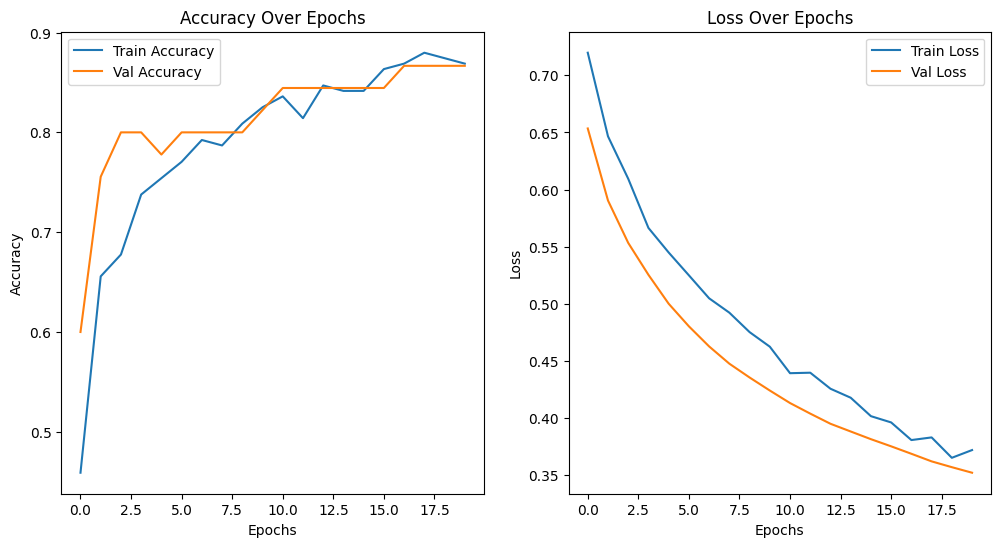

In [ ]:
# Visualize training results
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

VALIDATION

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 284ms/step - accuracy: 0.8705 - loss: 0.3219
validation Loss: 0.3522 - Validation Accuracy: 0.8667


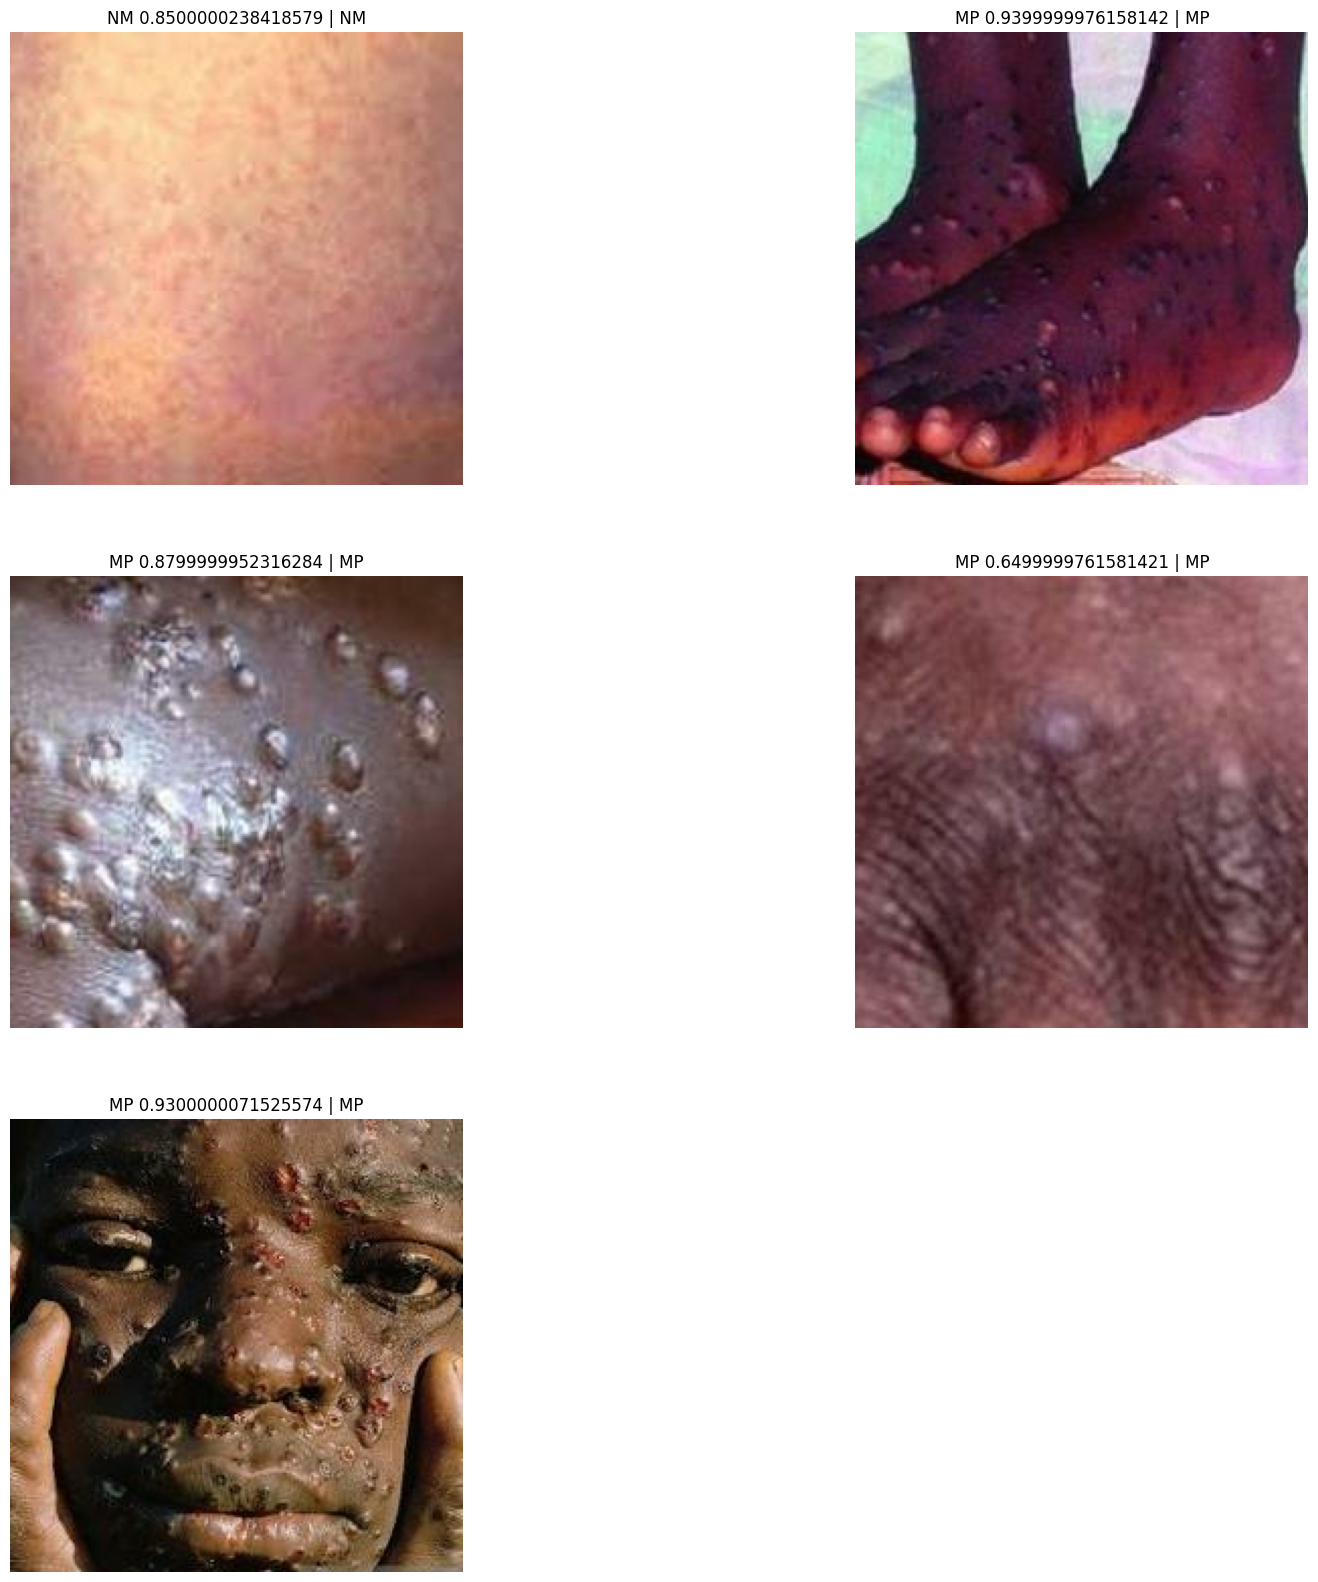

In [ ]:
# Visualizing predictions on validation set
class_names = ['MP', 'NM']

plt.figure(figsize=(20, 20))
for images, labels in val_ds.take(1):
    # Get the number of images in the batch
    num_images = len(images)
    # Calculate rows and columns for the subplot grid
    # You might need to adjust these based on your batch size
    num_rows = int(np.ceil(np.sqrt(num_images)))
    num_cols = int(np.ceil(num_images / num_rows))

    for i in range(num_images):
        result = model(np.expand_dims(images[i], axis=0))  # Make prediction for each image
        # Use num_rows and num_cols to dynamically create subplots
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class = class_names[np.argmax(result)]  # Get the predicted class
        true_class = class_names[np.argmax(labels[i])]  # Get the true class
        plt.title(f"{predicted_class} {round(np.max(result), 2)} | {true_class}")
        plt.axis("off")

# Evaluate the model on test set (assuming test_ds is available)
test_loss, test_accuracy = model.evaluate(val_ds)  # Use validation data here as a test
print(f"validation Loss: {test_loss:.4f} - Validation Accuracy: {test_accuracy:.4f}")

In [ ]:
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, log_loss

# Initialize lists to store true labels, predictions, and logits
true_labels = []
predicted_probs = []

# Iterate through the validation dataset (val_ds)
for X, y in tqdm(val_ds):  # Replace test_ds with val_ds
    for i in range(len(X)):
        # Get model outputs
        result = model(np.expand_dims(X[i], axis=0))

        # Store the true label
        true_labels.append(y[i].numpy())  # assuming y is a tensor

        # Store predicted probabilities (softmax output)
        predicted_probs.append(result.numpy())  # assuming result is a tensor

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_probs = np.concatenate(predicted_probs)

# Calculate accuracy
predicted_labels = np.argmax(predicted_probs, axis=1)
#  true_labels is one-hot encoded; if not, adjust accordingly
true_labels_flat = np.argmax(true_labels, axis=1)

accuracy = accuracy_score(true_labels_flat, predicted_labels)

# Calculate loss (log loss)
loss = log_loss(true_labels, predicted_probs)

print(f"Accuracy: {accuracy}")
print(f"Loss: {loss}")

100%|██████████| 9/9 [00:40<00:00,  4.55s/it]

Accuracy: 0.8666666666666667
Loss: 0.35221905856544666


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.74      0.82        19
           1       0.83      0.96      0.89        26

    accuracy                           0.87        45
   macro avg       0.88      0.85      0.86        45
weighted avg       0.88      0.87      0.86        45



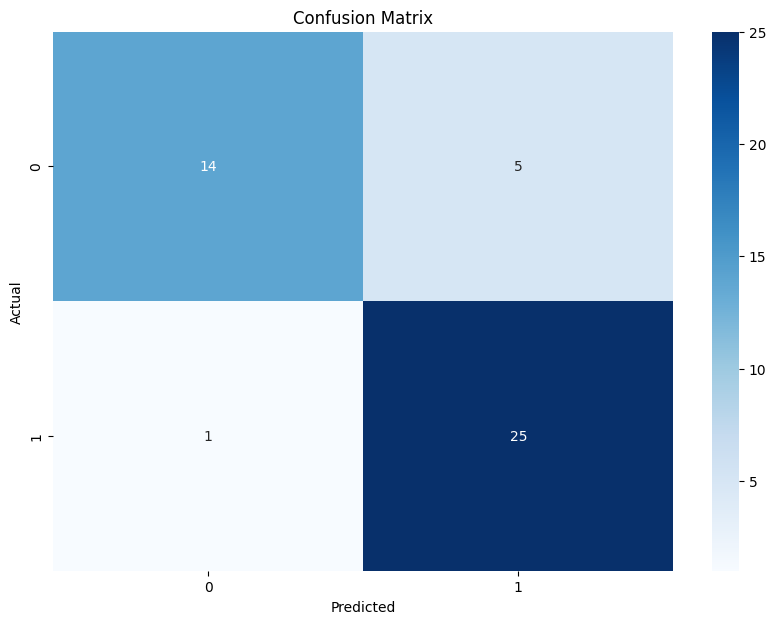

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns



# Step 1: Make predictions on the validation set and extract labels
val_labels = []  # Initialize an empty list to store true labels
val_predictions = []  # Initialize an empty list to store predictions

for images, labels in val_ds:
    val_labels.extend(np.argmax(labels.numpy(), axis=1))  # Append true labels
    predictions = model.predict(images)
    val_predictions.extend(np.argmax(predictions, axis=1))  # Append predicted labels

# Convert the lists to NumPy arrays
val_labels = np.array(val_labels)
val_predictions = np.array(val_predictions)

# Step 2: Compute the confusion matrix and classification report
cm = confusion_matrix(val_labels, val_predictions)
class_report = classification_report(val_labels, val_predictions)

print("Classification Report:")
print(class_report)

# Step 3: Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(val_labels), yticklabels=np.unique(val_labels))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

#TESTING

In [ ]:
import os
import cv2
import numpy as np

# Define the dataset path
dataset_path = '/content/drive/My Drive/Monkeypox'
mp_path = os.path.join(dataset_path, 'MP')  # Monkeypox images
nm_path = os.path.join(dataset_path, 'NM')  # Non-monkeypox images

# Define the function to load and preprocess images
def load_and_preprocess_images(folder_path, subfolders):
    label_map = {subfolder: idx for idx, subfolder in enumerate(subfolders)}
    images, labels = [], []

    for subfolder in subfolders:
        subfolder_path = os.path.join(folder_path, subfolder)
        for filename in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (224, 224))  # Resize to 224x224
                images.append(img)
                labels.append(label_map[subfolder])

    images = np.array(images).astype('float32') / 255.0  # Normalize images
    labels = np.array(labels)
    return images, labels

# Combine Monkeypox and Non-monkeypox images into one test set
subfolders = ['MP', 'NM']  # Subfolders: MP for Monkeypox, NM for Non-monkeypox
test_images, test_labels = load_and_preprocess_images(dataset_path, subfolders)

print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")


Test images shape: (228, 224, 224, 3)
Test labels shape: (228,)


In [ ]:
# Assuming the EfficientNetB0 model is named 'model' (as in the code you shared):

# Load the test dataset
test_ds = image_dataset_from_directory(
    dataset_path,
    label_mode='categorical',  # Ensure one-hot encoding
    image_size=(img_height, img_width),
    batch_size=batch_size,
    class_names=['MP', 'NM']  # Same class names as training
)

# Evaluate the EfficientNetB0 model on the test set
efficientnet_loss, efficientnet_accuracy = model.evaluate(test_ds, verbose=1)

# Print the results
print(f"EfficientNetB0 Model Test Loss: {efficientnet_loss:.4f} - Test Accuracy: {efficientnet_accuracy:.4f}")


Found 228 files belonging to 2 classes.
46/46 ━━━━━━━━━━━━━━━━━━━━ 19s 401ms/step - accuracy: 0.9130 - loss: 0.3374
EfficientNetB0 Model Test Loss: 0.3480 - Test Accuracy: 0.8860


Found 228 files belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

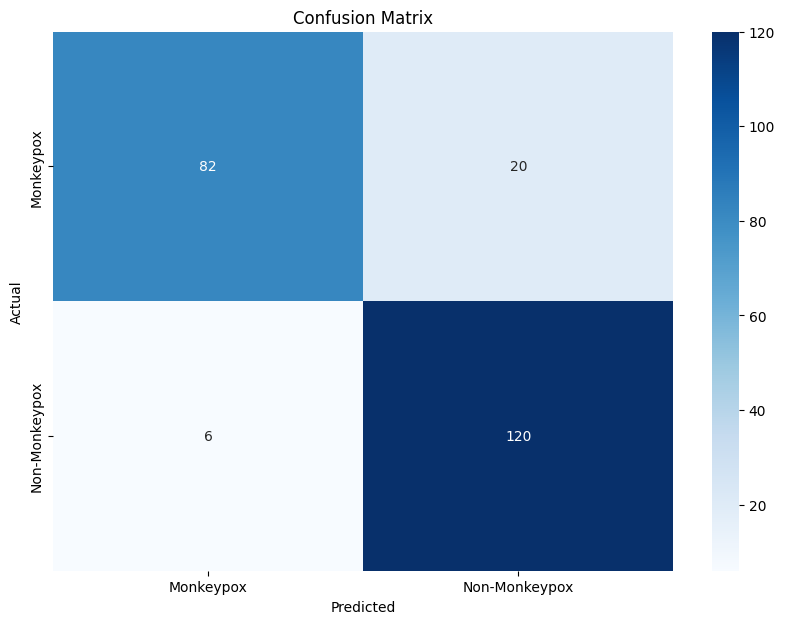

In [ ]:
# Step 1: Load the complete dataset (training + validation as a single dataset)
complete_ds = image_dataset_from_directory(
    dataset_path,
    label_mode='categorical',  # Use 'categorical' for one-hot encoded labels
    validation_split=None,     # Load the full dataset
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    class_names=['MP', 'NM']   # Specify the correct class labels
)

# Step 2: Make predictions on the complete dataset and extract labels
complete_labels = []  # Initialize an empty list to store true labels
complete_predictions = []  # Initialize an empty list to store predictions

for images, labels in complete_ds:
    complete_labels.extend(np.argmax(labels.numpy(), axis=1))  # Append true labels
    predictions = model.predict(images)
    complete_predictions.extend(np.argmax(predictions, axis=1))  # Append predicted labels

# Convert the lists to NumPy arrays
complete_labels = np.array(complete_labels)
complete_predictions = np.array(complete_predictions)

# Step 3: Compute the confusion matrix and classification report
cm = confusion_matrix(complete_labels, complete_predictions)
class_report = classification_report(complete_labels, complete_predictions, target_names=['Monkeypox', 'Non-Monkeypox'])

print("Classification Report:")
print(class_report)

# Step 4: Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Monkeypox', 'Non-Monkeypox'], yticklabels=['Monkeypox', 'Non-Monkeypox'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


#ROC

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

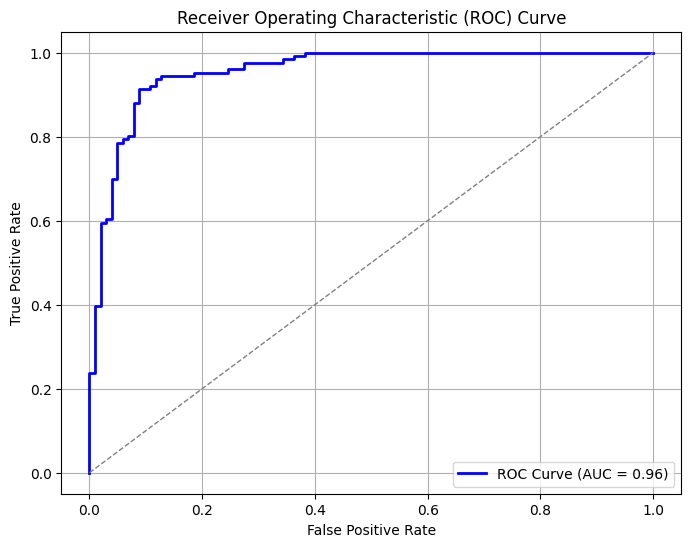

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Step 1: Get true labels and predicted probabilities for the complete dataset
complete_labels = []  # True labels
complete_probs = []   # Predicted probabilities

for images, labels in complete_ds:
    complete_labels.extend(np.argmax(labels.numpy(), axis=1))  # True labels (convert from one-hot)
    predictions = model.predict(images)  # Get predicted probabilities
    complete_probs.extend(predictions[:, 1])  # Probabilities for class '1' (Non-Monkeypox)

# Convert to NumPy arrays
complete_labels = np.array(complete_labels)
complete_probs = np.array(complete_probs)

# Step 2: Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(complete_labels, complete_probs)
roc_auc = auc(fpr, tpr)

# Step 3: Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


#COMPUTATIONAL COMPLEXITY

In [ ]:
def get_model_memory_usage(model, batch_size=1):
    """Calculates the approximate memory usage of a Keras model.

    Args:
        model: The Keras model.
        batch_size: The batch size used for inference.

    Returns:
        The approximate memory usage of the model in megabytes (MB).
    """
    # Memory for model parameters
    trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_variables])
    non_trainable_params = np.sum([np.prod(v.shape) for v in model.non_trainable_variables])
    total_params = trainable_params + non_trainable_params
    params_memory = total_params * 4  # Assuming 32-bit floats (4 bytes per float)

    # Memory for activations (forward pass only)
    feature_map_memory = 0
    for layer in model.layers:

        # Check if the layer has an output_shape attribute
        if hasattr(layer, 'output_shape'):
            output_shape = layer.output_shape

            # Check if output_shape is valid for calculation
            if output_shape and all(dim is not None for dim in output_shape):
                if isinstance(output_shape, list):  # Multiple outputs
                    feature_map_memory += sum([np.prod(shape) for shape in output_shape if shape])
                else:
                    feature_map_memory += np.prod(output_shape)

    feature_map_memory *= batch_size * 4  # 32-bit floats

    total_memory = params_memory + feature_map_memory
    return total_memory / (1024 ** 2)  # Convert to MB
# Call the function with your model and batch size
memory_usage = get_model_memory_usage(model, batch_size=1)

# Print the memory usage
print(f"Approximate Model Memory Usage: {memory_usage:.2f} MB")


Approximate Model Memory Usage: 17.95 MB


In [ ]:
import tensorflow as tf

def get_model_flops(model, batch_size=5, input_shape=(224, 224, 3)):
    """
    Calculate the FLOPs (Floating Point Operations) of the model.

    Args:
        model: The Keras model.
        batch_size: The batch size used for inference.
        input_shape: The shape of the input tensor (excluding batch size).

    Returns:
        The approximate number of FLOPs for a single forward pass of the model.
    """
    dy_input = tf.random.normal([batch_size] + list(input_shape))

    # Create a concrete function from the model
    concrete_func = tf.function(model).get_concrete_function(dy_input)

    # Use TensorFlow's profiler to trace the operations and calculate FLOPs
    flops = tf.compat.v1.profiler.profile(
        graph=concrete_func.graph,
        options=tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    )

    # Print the total FLOPs (in GFLOPs)
    total_flops = flops.total_float_ops
    print(f"Total FLOPs: {total_flops}")
    print(f"Approximate FLOPs for a forward pass: {total_flops / 1e9:.2f} GFLOPs")
    return total_flops

# Get and print the FLOPs of the model
flops = get_model_flops(model, batch_size=5, input_shape=(224, 224, 3))

Total FLOPs: 4009988131
Approximate FLOPs for a forward pass: 4.01 GFLOPs


In [ ]:
import time
import numpy as np

# Generate a random input tensor with the same shape as the model's input
input_shape = (1, 224, 224, 3)  # Adjust as per your model's input dimensions
random_input = np.random.random(input_shape).astype(np.float32)

# Warm-up the model to ensure accurate timing (optional but recommended)
for _ in range(5):
    _ = model.predict(random_input)

# Measure inference time
start_time = time.time()
_ = model.predict(random_input)  # Perform a single forward pass
end_time = time.time()

# Calculate and print the inference time
inference_time = end_time - start_time
print(f"Inference Time for a single input: {inference_time:.6f} seconds")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Inference Time for a single input: 0.146560 seconds


#ENSEMBLE

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_21             │ (None, 512)            │     24,636,800 │ input_layer_14[0][0]   │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_22             │ (None, 512)            │      4,705,443 │ input_layer_14[0][0]   │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_23             │ (None, 512)            │      2,913,856 │ input_layer_14[0][0]   │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average (Average)         │ (None, 512)            │              0 │ functional_21[0][0],   │
│                           │                        │                │ functional_22[0][0],   │
│                           │                        │                │ functional_23[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_17 (Dense)          │ (None, 512)            │        262,656 │ average[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_18 (Dense)          │ (None, 2)              │          1,026 │ dense_17[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 32,519,781 (124.05 MB)

 Trainable params: 2,624,514 (10.01 MB)

 Non-trainable params: 29,895,267 (114.04 MB)

Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.5433 - loss: 0.6916 - val_accuracy: 0.5333 - val_loss: 0.7090
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.7127 - loss: 0.6419 - val_accuracy: 0.7111 - val_loss: 0.6531
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.7241 - loss: 0.6068 - val_accuracy: 0.7778 - val_loss: 0.6133
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8069 - loss: 0.5532 - val_accuracy: 0.8000 - val_loss: 0.5804
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.8422 - loss: 0.5307 - val_accuracy: 0.8000 - val_loss: 0.5500
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8464 - loss: 0.5016 - val_accuracy: 0.8222 - val_loss: 0.5245
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.8698 - loss: 0.4774 - val_accuracy: 0.8222 - val_loss: 0.5045
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.8927 - loss: 0.4473 - val_accuracy: 0.8222 - val_loss

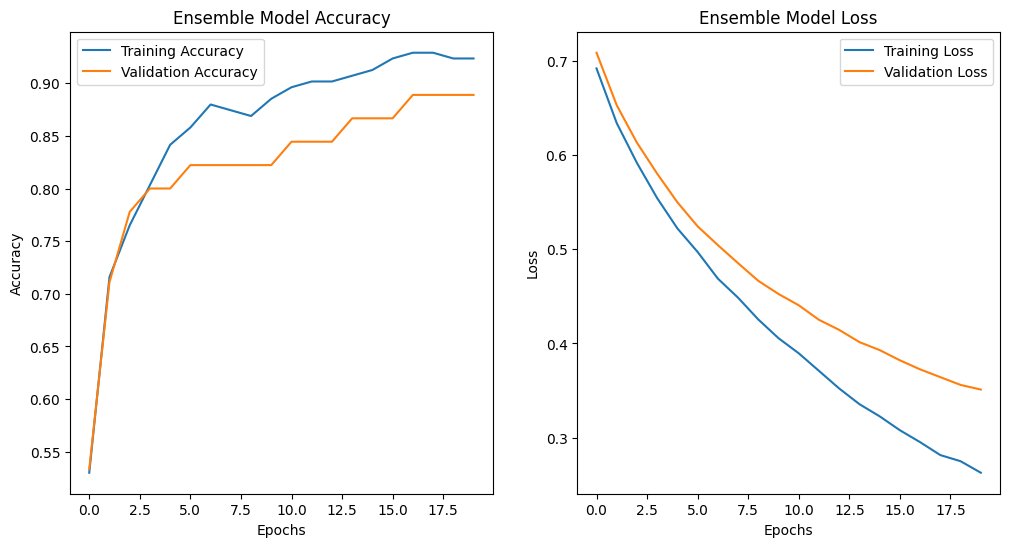

In [ ]:
from tensorflow.keras.layers import Dense, Average, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50, EfficientNetB0, MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define base model function
def create_base_model(base_model, input_shape=(224, 224, 3), output_dim=512):
    model = base_model(include_top=False, input_shape=input_shape, pooling='avg', weights='imagenet')
    for layer in model.layers:
        layer.trainable = False
    input_layer = Input(shape=input_shape)
    x = model(input_layer)
    x = Dense(output_dim, activation='relu')(x)  # Unify output shape
    return Model(inputs=input_layer, outputs=x)

# Define input layer
input_layer = Input(shape=(224, 224, 3))

# Create individual models
resnet_model = create_base_model(ResNet50, output_dim=512)(input_layer)
efficientnet_model = create_base_model(EfficientNetB0, output_dim=512)(input_layer)
mobilenet_model = create_base_model(MobileNetV2, output_dim=512)(input_layer)

# Average the outputs
merged = Average()([resnet_model, efficientnet_model, mobilenet_model])

# Add fully connected layers
x = Dense(512, activation='relu')(merged)
output_layer = Dense(2, activation='softmax')(x)

# Define the ensemble model
ensemble_model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
ensemble_model.compile(optimizer=Adam(learning_rate=0.00001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Print the model summary
ensemble_model.summary()

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the ensemble model
history = ensemble_model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=[early_stop])

# Evaluate the ensemble model on the validation set
val_loss, val_accuracy = ensemble_model.evaluate(val_ds)
print(f"Ensemble Model Validation Loss: {val_loss:.4f}")
print(f"Ensemble Model Validation Accuracy: {val_accuracy:.4f}")

# Optionally, visualize training history (accuracy and loss)
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Ensemble Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Ensemble Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
# Load the test dataset
test_ds = image_dataset_from_directory(
    dataset_path,
    label_mode='categorical',  # Ensure one-hot encoding
    image_size=(img_height, img_width),
    batch_size=batch_size,
    class_names=['MP', 'NM']  # Ensure consistent class names
)

# Evaluate the ensemble model on the test set
ensemble_loss, ensemble_accuracy = ensemble_model.evaluate(test_ds, verbose=1)

# Print the results
print(f"Ensemble Model Test Loss: {ensemble_loss:.4f}")
print(f"Ensemble Model Test Accuracy: {ensemble_accuracy:.4f}")


Found 228 files belonging to 2 classes.
46/46 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.9396 - loss: 0.2556
Ensemble Model Test Loss: 0.2671
Ensemble Model Test Accuracy: 0.9298


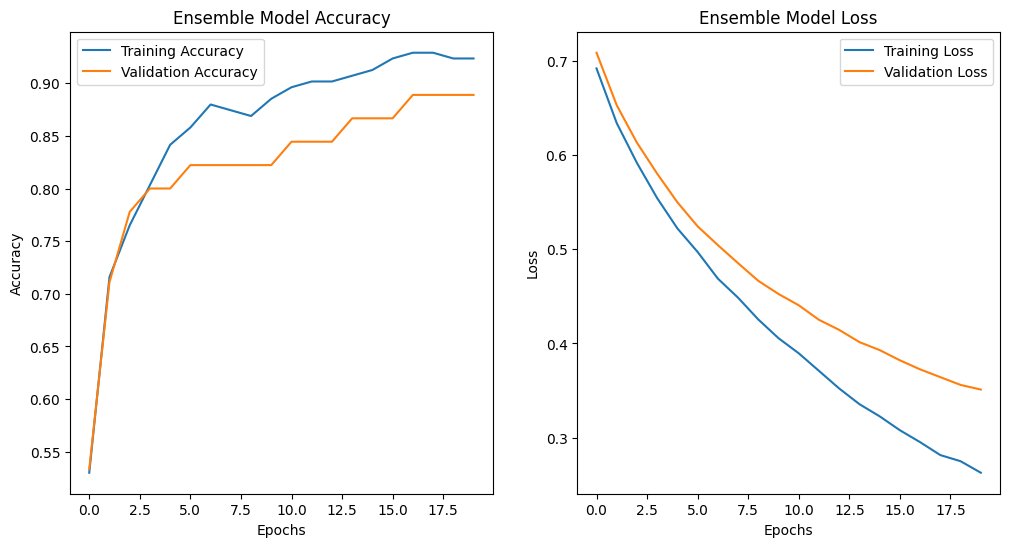

In [ ]:
import matplotlib.pyplot as plt

# Visualize training history (accuracy and loss)
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Ensemble Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Ensemble Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
# Extract the best validation accuracy
best_val_accuracy = max(history.history['val_accuracy'])
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")


Best Validation Accuracy: 0.8889
